# Impact of Barren Plateaus Mitigation Strategy on the Performance of Quantum Neural Networks
*Training QNN treated with method 3 (Identity Blocks) of the BP mitigation strategy (MNIST)*

**Authors:**
- Jacob Cybulski and Thanh Nguyen

**Date:**
- June 2023

**Data:**
- Data = IRIS dataset with 500 examples
- Features = 4 top PCA components
- Target = {-1, 1}
- Iterations = 120
- Instance = 10

**Description:**
- This notebook aims to train 10 instances of a QNN initialised with identity blocks and produce averaged performance stats

In [1]:
import copy, math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F

from qiskit.algorithms.optimizers import COBYLA, NELDER_MEAD, SLSQP, SPSA
from qiskit.opflow import Z, I, StateFn, PauliExpectation, Gradient, NaturalGradient, PauliSumOp
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import VQC, NeuralNetworkClassifier
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
# algorithm_globals.random_seed = 42

from IPython.display import clear_output

/var/folders/yl/5cj99xpd0cg5xn4st7_dyz6m0000gn/T/ipykernel_82741/884590504.py:10: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, NELDER_MEAD, SLSQP, SPSA


In [2]:
from Components.circuits import preTrainedBlockGenerator, layerwise_training, featureMapGenerator, AnsatzGenerator
from Components.data import cancer_data
from Components.utils import plot_loss, score, parity, classification_callback, plot_objfn_range, result_to_objfun_dataframes, save_results
from Components.train import create_qnn, sampling_experiment, train, train_batch

In [3]:
# Global config for all experiments (data size, feature dim etc.) is stored here
from GLOBAL_CONFIG import *
# Remember to tag the method
METHOD_TAG = 'm0'

In [4]:
X_train, X_val, y_train, y_val = cancer_data(PCA_n = FEATURE_DIM)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 398 samples
Testing set: 171 samples
Number of features: 4
Classes:[0 1]; Encoded as: [-1  1]


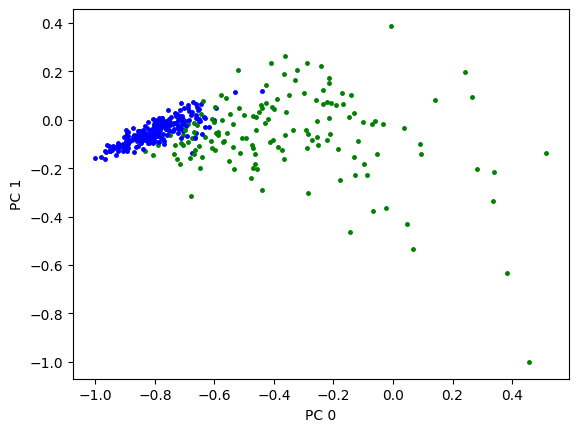

Blue: torch.Size([250])
Green: torch.Size([148])


In [5]:
# Plot dataset (only the first two args)
for x, y_target in zip(X_train_t, y_train_t):
    if y_target == 1:
        plt.plot(x[0], x[1], color="blue", marker=".", markersize=5)
    else:
        plt.plot(x[0], x[1], color="green", marker=".", markersize=5)
plt.xlabel('PC 0')
plt.ylabel('PC 1')
plt.show()

rows_b = np.where(np.array(y_train_t)==1)
rows_g = np.where(np.array(y_train_t)==-1)
print('Blue:', y_train_t[rows_b].size())
print('Green:', y_train_t[rows_g].size())

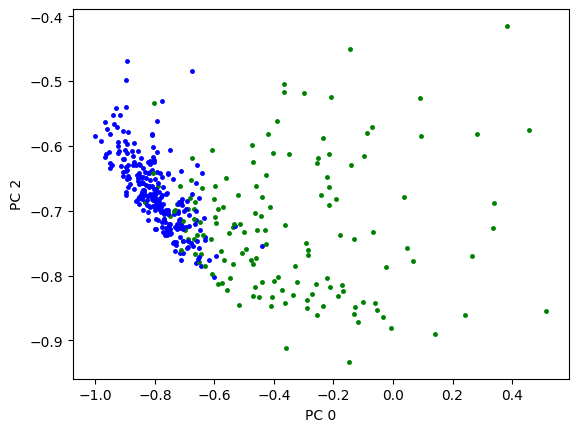

Blue: torch.Size([250])
Green: torch.Size([148])


In [6]:
# Plot dataset (only the first and the third arg)
for x, y_target in zip(X_train_t, y_train_t):
    if y_target == 1:
        plt.plot(x[0], x[2], color="blue", marker=".", markersize=5)
    else:
        plt.plot(x[0], x[2], color="green", marker=".", markersize=5)
plt.xlabel('PC 0')
plt.ylabel('PC 2')
plt.show()

rows_b = np.where(np.array(y_train_t)==1)
rows_g = np.where(np.array(y_train_t)==-1)
print('Blue:', y_train_t[rows_b].size())
print('Green:', y_train_t[rows_g].size())

In [7]:
def plot_method_data(data, title='Instance Losses', dlabel='inst#', xlabel='Loss', ylabel='Iteration'):
    # create figure and axis
    fig, ax = plt.subplots()
    fig.set_figheight(4)
    fig.set_figwidth(8)
    
    # setting the axis' labels
    ax.set_ylabel(xlabel)
    ax.set_xlabel(ylabel)
    
    # Plot data
    for i in range(len(data)):
        data[i].T.plot(ax=ax, label=f'inst# {i}', figsize=(5, 3))
    ax.legend([f'{dlabel} {i}' for i in range(len(data))])
    plt.title(title)
    plt.show()  

## Method 0 (General)

In [8]:
from qiskit.primitives import Estimator # Statevector estimator
from os.path import exists
from os import makedirs

In [9]:
feature_map = featureMapGenerator(FEATURE_DIM)
ansatz = AnsatzGenerator(FEATURE_DIM, MAX_REPS, ENTANGLEMENT)
qc = feature_map.compose(ansatz)

In [10]:
# To execute on multiple machines concurrently
# Select separate sub-lists of instance numbers and run
# Alternatively use range(MAX_INST) for all

m = METHOD_TAG
path = LOG_PATH

# for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]: 
for i in [0]: 
    
    # Mark that the method's data has been saved
    if (exists(f'{path}/{m}')):
        print(f'Adding a new instance {i} of method {m}\n')
    else:
        makedirs(f'{path}/{m}')
        print(f'Creating the first instance {i} of method {m}\n')
        
    # By default this will run as a local simulation
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=Estimator(),
        observables=GLOBAL_OPERATOR,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )

    # By default random initialisation
    model = TorchConnector(qnn)

    loss_function = nn.L1Loss() # nn.MSELoss()
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

    model, losses, accuracy_train, accuracy_test, weights = train(
        model, 
        MAX_ITER, 
        X_train_t,
        y_train_t,
        X_val_t,
        y_val_t,
        optimizer = optimizer, 
        loss_function = loss_function
        )

    pd.DataFrame(losses).astype('float').to_csv(f'{path}/{m}/{m}-{i}-LossFunction.csv')
    pd.DataFrame(accuracy_train).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Scores-Train.csv')
    pd.DataFrame(accuracy_test).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Scores-Test.csv')
    pd.DataFrame(weights).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Weights.csv')
    
    # Mark that the method's data has been saved
    if (exists(f'{path}/{m}/{m}-Method.csv')):
        f = open(f'{path}/{m}/{m}-Method.csv', 'a')
    else:
        f = open(f'{path}/{m}/{m}-Method.csv', 'w')
        f.write(f'{m},Instance,Max Inst,Examples,Features,Iterations\n')
    f.write(f',{i},{MAX_INST},{DATA_SIZE},{FEATURE_DIM},{MAX_ITER}\n')
    f.close()
    
    clear_output(wait=True)

Creating the first instance 0 of method m0

Epoch      Loss                 Train Accuracy   Test Accuracy   
[ 0 ]      1.1005500555038452   0.33166          0.35088         
[ 10 ]     0.6523100137710571   0.79397          0.81871         
[ 20 ]     0.5846499800682068   0.80905          0.82456         
[ 30 ]     0.5575399994850159   0.78141          0.80702         
[ 40 ]     0.5372099876403809   0.77638          0.77778         
[ 50 ]     0.5338900089263916   0.80151          0.79532         
[ 60 ]     0.5350099802017212   0.79899          0.80702         
[ 70 ]     0.5327500104904175   0.79397          0.80117         
[ 80 ]     0.5319200158119202   0.79397          0.80117         
[ 90 ]     0.5330399870872498   0.79146          0.80117         
[ 100 ]    0.5321800112724304   0.78894          0.80117         
[ 110 ]    0.5303599834442139   0.78392          0.79532         
[ 119 ]    0.530430018901825    0.76131          0.77193         


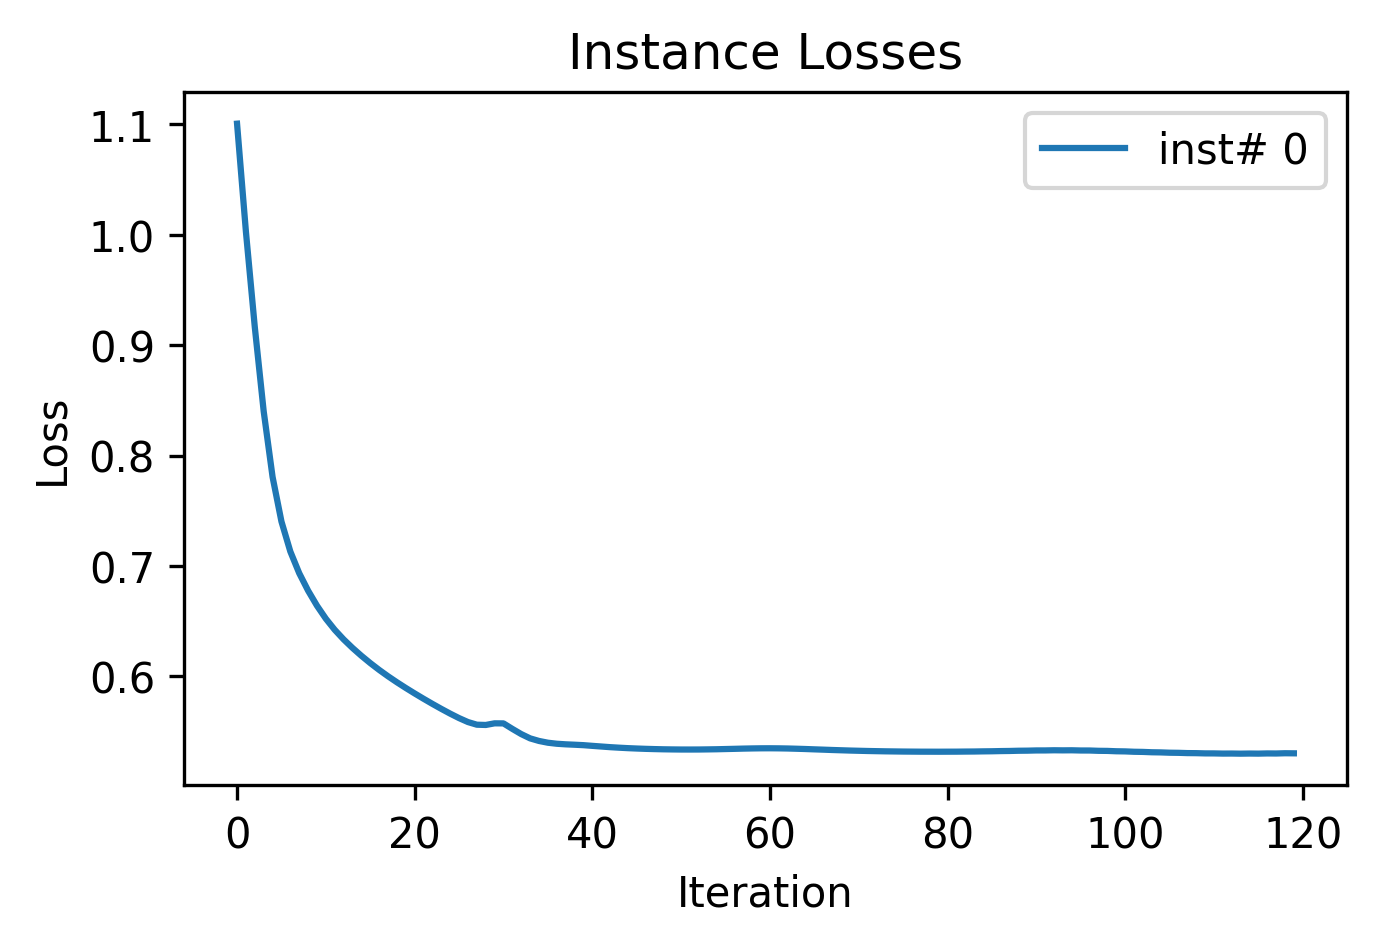

In [11]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Plot the loss of the last saved instance
plot_method_data([pd.DataFrame(losses).astype('float').T])

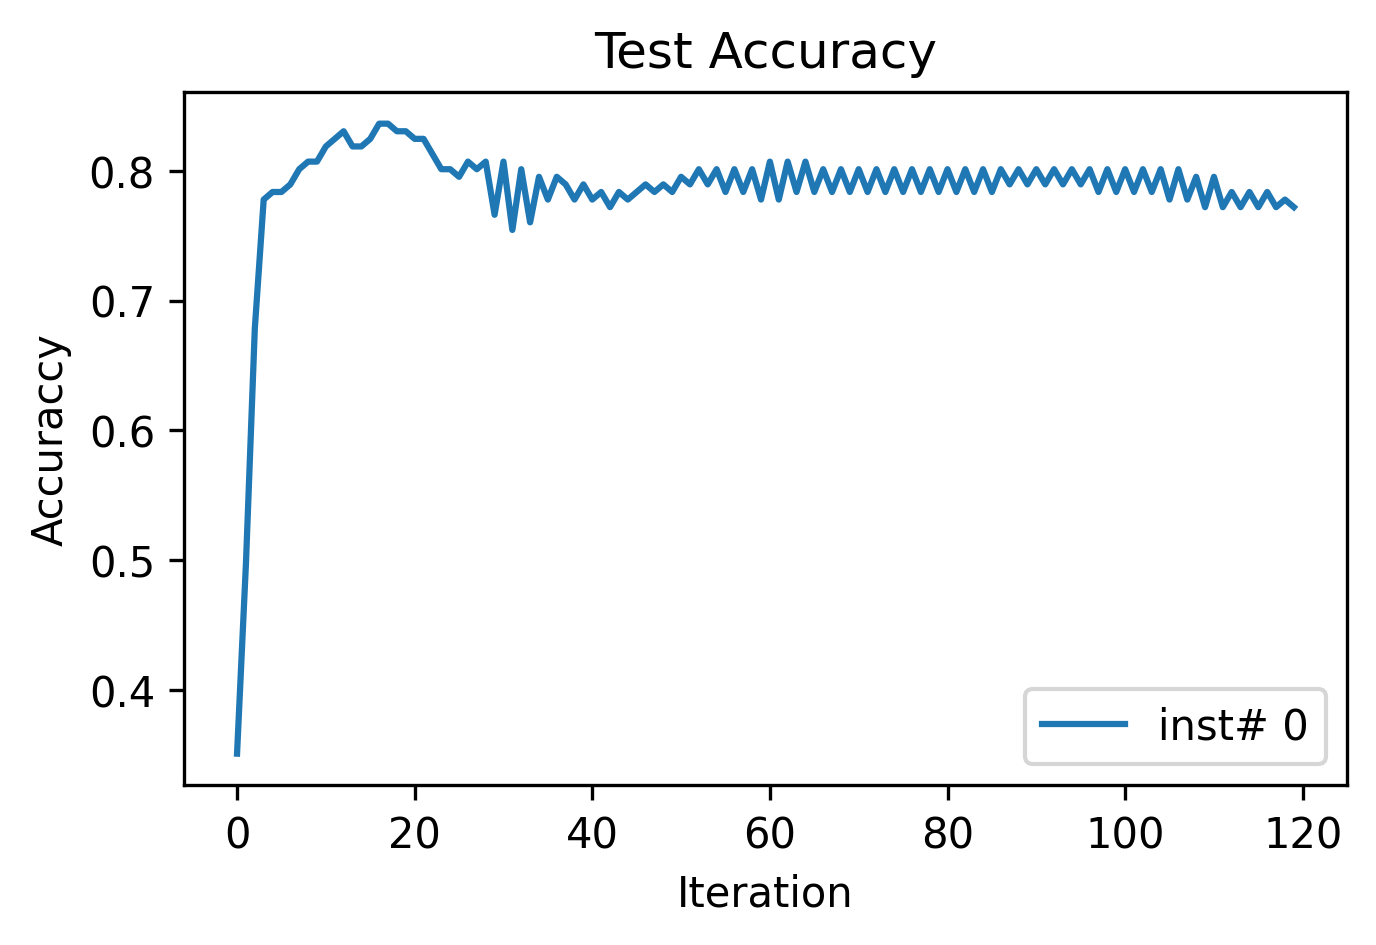

In [12]:
# Plot the loss of the last saved instance
plot_method_data([pd.DataFrame(accuracy_test).astype('float').T],
                title='Test Accuracy', dlabel='inst#', xlabel='Accuraccy', ylabel='Iteration')

In [13]:
!pip list | grep qiskit

qiskit                    0.45.0
qiskit-algorithms         0.2.1
qiskit-ibm-provider       0.7.2
qiskit-ibm-runtime        0.15.1
qiskit-machine-learning   0.7.0
qiskit-terra              0.45.0

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [14]:
!pip list | grep torch

torch                     1.11.0
torchsummary              1.5.1
torchvision               0.14.1

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
